In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
import random

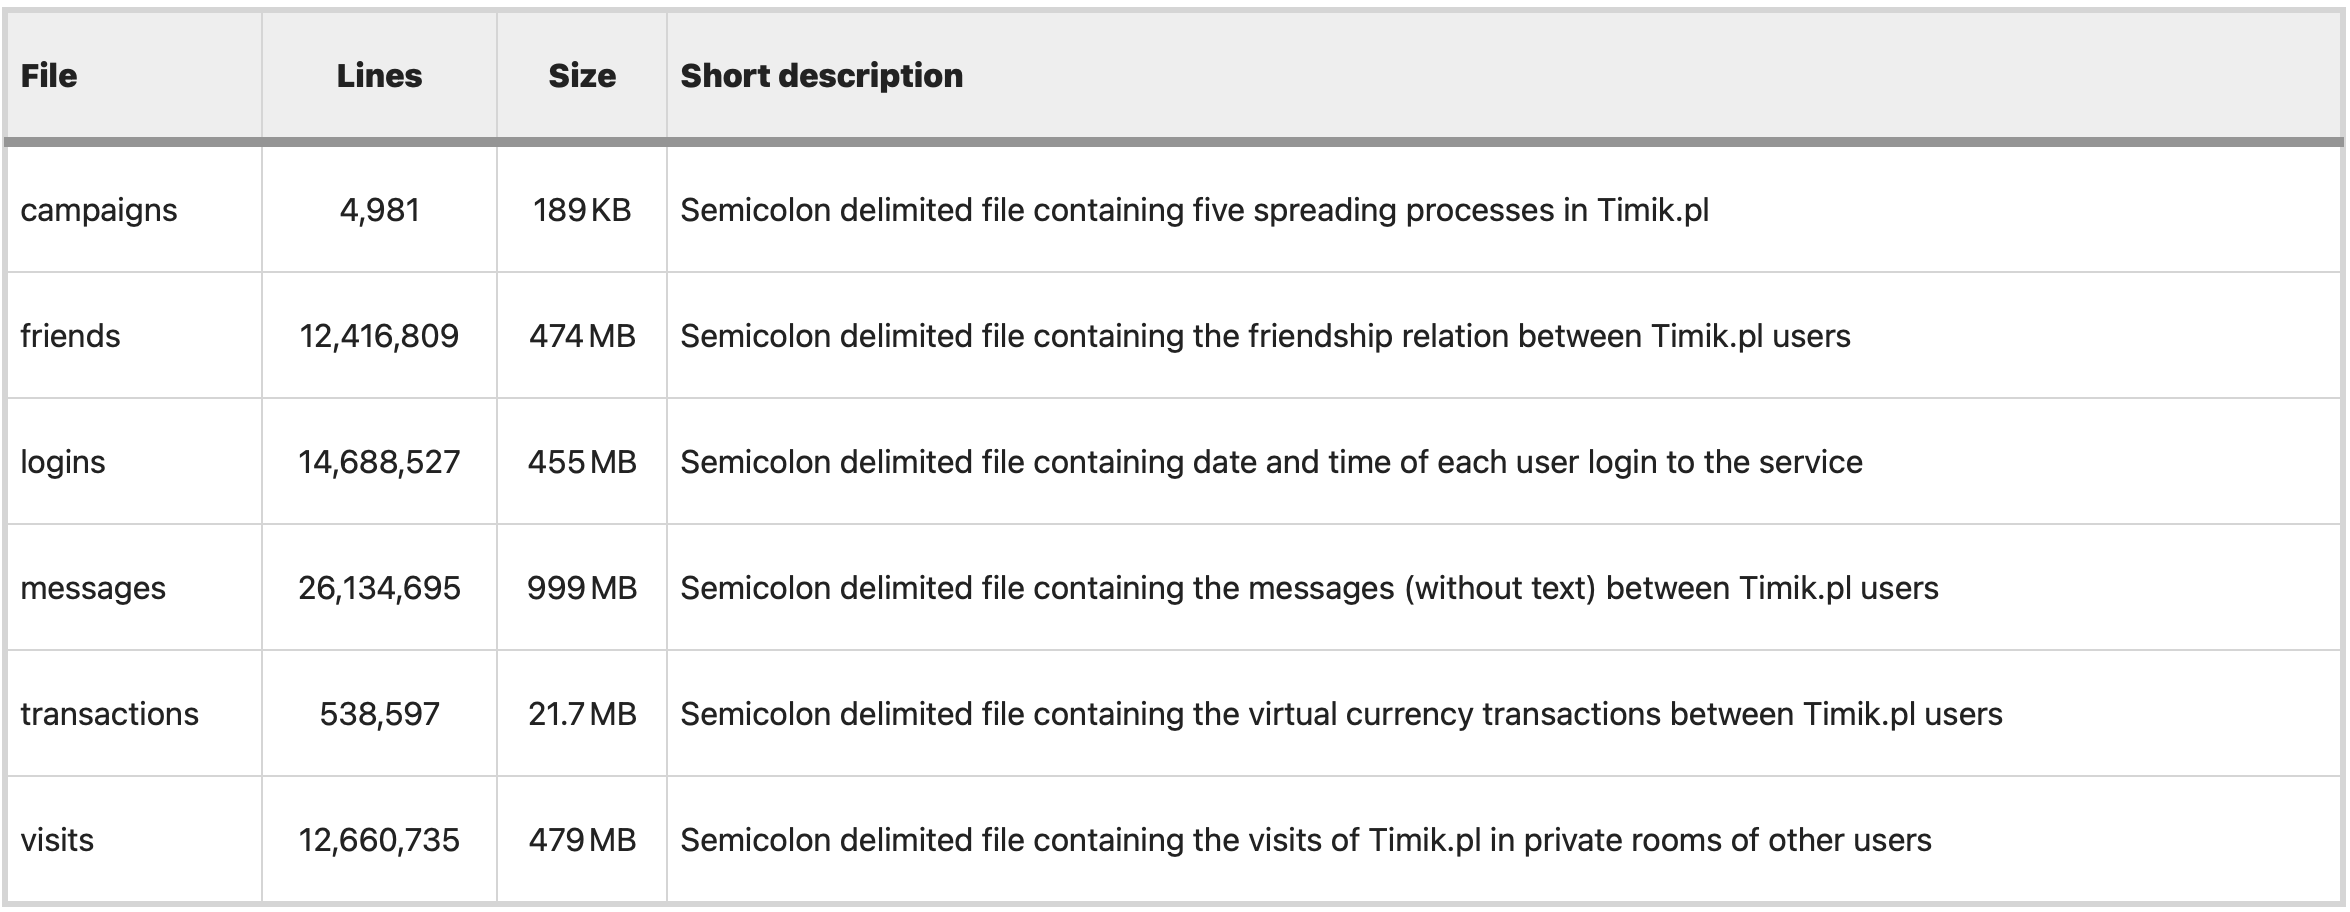

In [2]:
from IPython.display import Image, display

# show table
display(Image(filename='table1.png'))

In [3]:
campaigns = pd.read_csv('data/campaigns.csv', sep=';', header=None)
campaigns.columns = ['campaign_id', 'timestamp', 'sender_id', 'receiver_id']
friends = pd.read_csv('data/friends.csv', sep=';', header=None)
friends.columns = ['timestamp', 'sender_id', 'receiver_id']
messages = pd.read_csv('data/messages.csv', sep=';', header=None)
messages.columns = ['timestamp', 'sender_id', 'receiver_id']
transactions = pd.read_csv('data/transactions.csv', sep=';', header=None)
transactions.columns = ['timestamp', 'sender_id', 'receiver_id', 'amount']
visits = pd.read_csv('data/visits.csv', sep=';', header=None)
visits.columns = ['timestamp', 'sender_id', 'receiver_id']

In [4]:
campaigns.head()

,campaign_id,timestamp,sender_id,receiver_id
0,1,2010-10-31 15:04:00,16453,16454
1,1,2010-10-31 15:04:00,16453,16455
2,1,2010-10-31 15:04:00,16453,16456
3,1,2010-10-31 15:04:00,16453,16457
4,1,2010-10-31 15:04:00,16453,16458


# Community Detection Algorithm

## Multi-View Spectral Clustering on Multilayer Networks

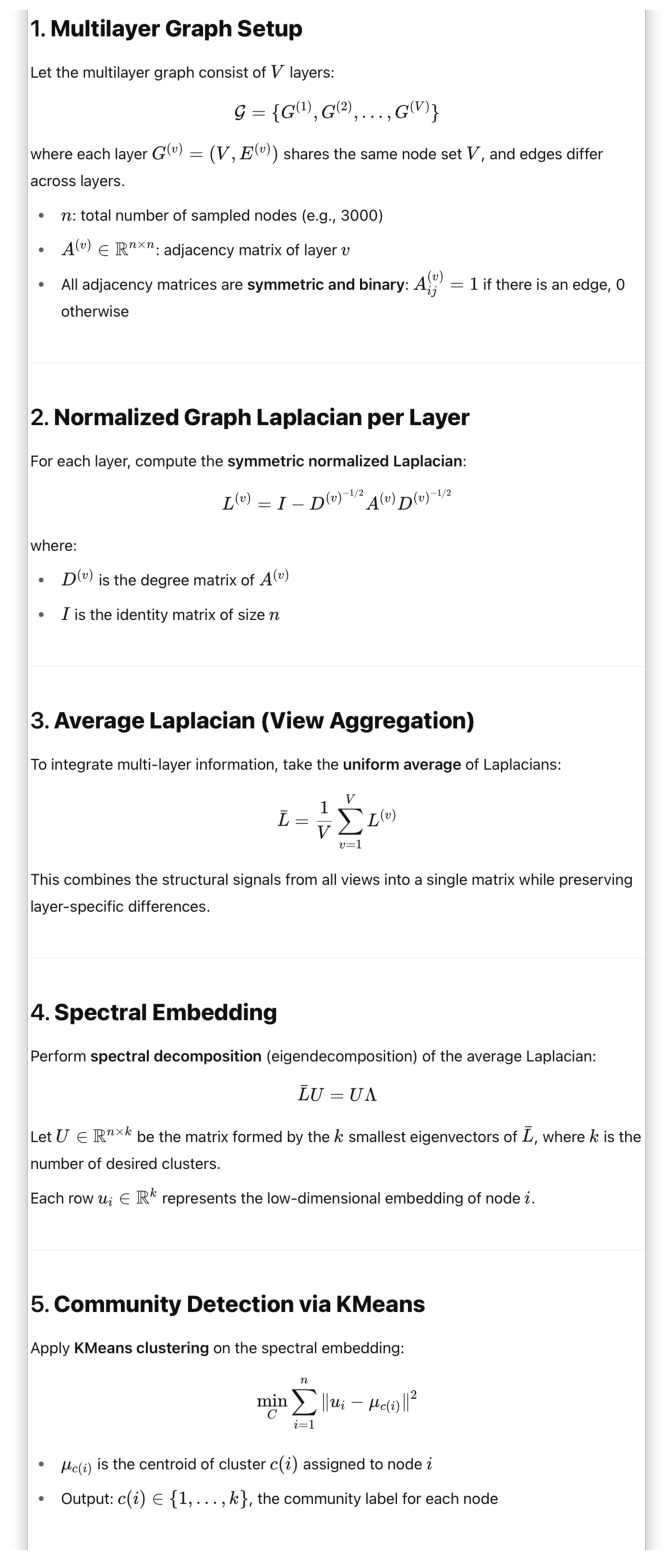

In [5]:
import matplotlib.image as mpimg

img = mpimg.imread('commuity_algorithm.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# ----- Load Edge Data -----
def load_edges(file_path, columns):
    df = pd.read_csv(file_path, sep=';', header=None, usecols=range(len(columns)))
    df.columns = columns
    return df[['sender_id', 'receiver_id']]

# ----- Build Sparse Adjacency Matrix -----
def build_sparse_adjacency(edge_df, user_index):
    edge_df = edge_df[edge_df['sender_id'].isin(user_index) & edge_df['receiver_id'].isin(user_index)]
    row = edge_df['sender_id'].map(user_index).values
    col = edge_df['receiver_id'].map(user_index).values
    data = np.ones(len(row))
    n = len(user_index)
    A = csr_matrix((data, (row, col)), shape=(n, n))
    A = A + A.T
    A[A > 1] = 1
    return A

# ----- Normalized Laplacian (Sparse) -----
def normalized_laplacian_sparse(A):
    degrees = np.array(A.sum(axis=1)).flatten()
    degrees[degrees == 0] = 1e-12
    D_inv_sqrt = csr_matrix(np.diag(1.0 / np.sqrt(degrees)))
    L = csr_matrix(np.eye(A.shape[0])) - D_inv_sqrt @ A @ D_inv_sqrt
    return L

# ----- Multi-view Clustering -----
def multi_view_clustering(adj_list, k):
    L_total = sum(normalized_laplacian_sparse(A) for A in adj_list)
    L_avg = L_total / len(adj_list)
    vals, vecs = eigsh(L_avg, k=k, which='SM')
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(vecs)
    return labels, vecs

# ----- Visualize -----
def plot_clusters(embedding, labels):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embedding)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.title("Multi-View Spectral Clustering (Sampled Users)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter, label='Community')
    plt.show()

In [7]:
# Active user sampling
print("Collecting active user IDs...")
all_ids = pd.concat([campaigns, friends, messages, transactions, visits]).stack()
tqdm.pandas(desc="Counting user frequency")
top_users = all_ids.value_counts().head(3000).index.tolist()
user_index = {uid: i for i, uid in enumerate(top_users)}
print(f"Selected top {len(user_index)} active users.")

Selected top 3000 active users.


In [8]:
# Build adjacency matrices with progress
adj_matrices = []
layer_names = ['Campaigns', 'Friends', 'Messages', 'Transactions', 'Visits']
layer_data = [campaigns, friends, messages, transactions, visits]

print("Building sparse adjacency matrices...")
for name, df in tqdm(zip(layer_names, layer_data), total=5, desc="Building matrices"):
    A = build_sparse_adjacency(df, user_index)
    adj_matrices.append(A)

Building sparse adjacency matrices...


Building matrices: 100%|██████████████████████████| 5/5 [00:16<00:00,  3.36s/it]


In [9]:
# Perform clustering
print("Computing Laplacians and performing spectral embedding...")
labels, embedding = multi_view_clustering(adj_matrices, k=5)

Computing Laplacians and performing spectral embedding...


/Users/einstean/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visualizing communities...


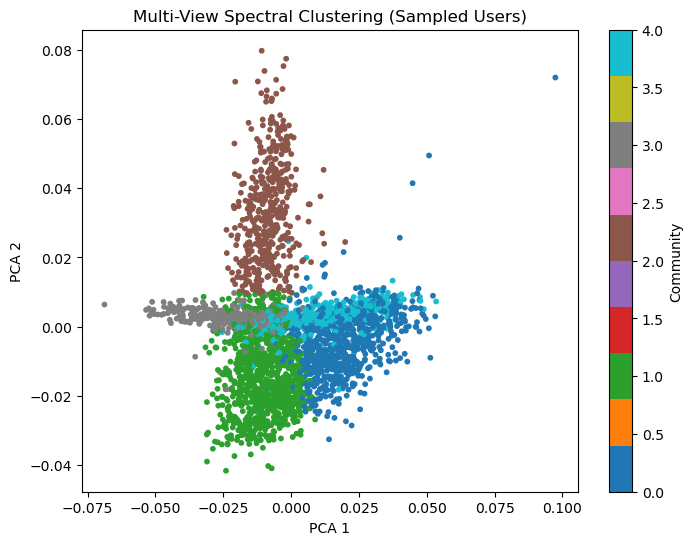

In [10]:
# Visualization
print("Visualizing communities...")
plot_clusters(embedding, labels)

In [ ]:
# Export results
print("Saving community results to CSV...")
id2label = {uid: labels[i] for uid, i in user_index.items()}
pd.DataFrame(list(id2label.items()), columns=['user_id', 'community_label'])\
    .to_csv('./table/community_result_5layers.csv', index=False)
print("Saved to community_result_5layers.csv")

print("Pipeline completed.")

Saving community results to CSV...
Saved to community_result_5layers.csv
Pipeline completed.


In [ ]:
import plotly.graph_objects as go

def draw_3d_fused_network(embedding, labels, adj_list, sample_size=500):
    
    # Combine adjacency matrices
    A_combined = sum(adj_list) / len(adj_list)
    A_combined = A_combined.tocsr()

    # Build graph and sample nodes
    G = nx.from_scipy_sparse_array(A_combined)
    idx_sample = np.random.choice(len(labels), size=min(sample_size, len(labels)), replace=False)
    label_colors = [labels[i] for i in idx_sample]

    # Prepare node positions from spectral embedding
    x = embedding[idx_sample, 0]
    y = embedding[idx_sample, 1]
    z = embedding[idx_sample, 2]* 10.0

    # Prepare edge traces
    edge_x, edge_y, edge_z = [], [], []
    
    # Sample edges for visualization
    edges = list(G.subgraph(idx_sample).edges())
    edges_sample = random.sample(edges, min(1000, len(edges)))
    
    # Prepare edge traces
    edge_x, edge_y, edge_z = [], [], []
    for i, j in edges_sample:
        edge_x += [embedding[i, 0], embedding[j, 0], None]
        edge_y += [embedding[i, 1], embedding[j, 1], None]
        edge_z += [embedding[i, 2] * 10.0, embedding[j, 2] * 10.0, None]


    # Plot with Plotly
    fig = go.Figure()

    # Edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='gray', width=1),
        hoverinfo='none'
    ))

    # Nodes
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=label_colors,
            colorscale='Viridis',
            opacity=0.85
        ),
        hoverinfo='text',
        hovertext=[f'Node {i}, Cluster {labels[i]}' for i in idx_sample]
    ))

    fig.update_layout(
        title='3D Multi-layer Network with Community Clusters',
        margin=dict(l=0, r=0, b=0, t=40),
        scene=dict(xaxis_title='Dim 1', yaxis_title='Dim 2', zaxis_title='Dim 3')
    )
    fig.write_html("./html/community_network.html")
    fig.show()

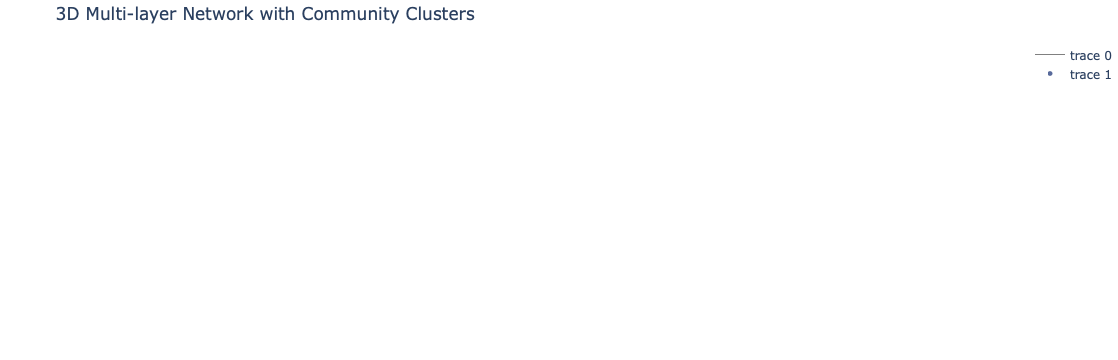

In [ ]:
os.makedirs("./html", exist_ok=True)
draw_3d_fused_network(embedding*5, labels, adj_matrices, sample_size=100)